In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from core.model_tester import ModelTester
from core.categorizer import Categorizer
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

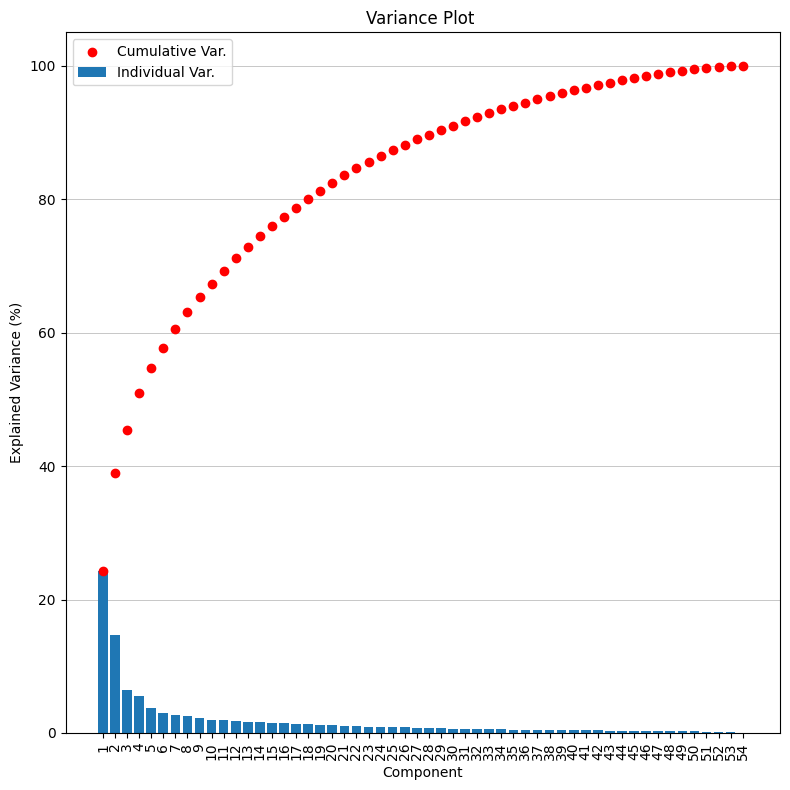

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


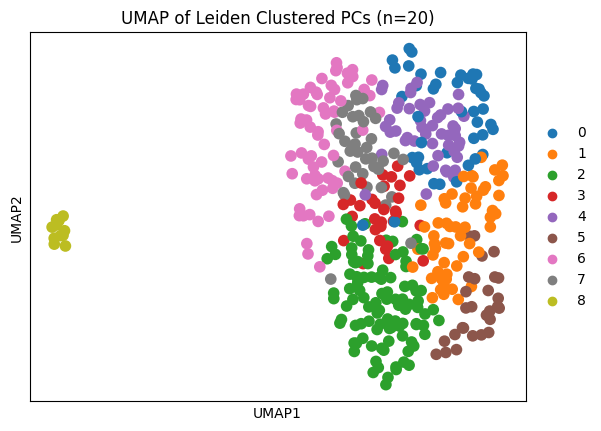

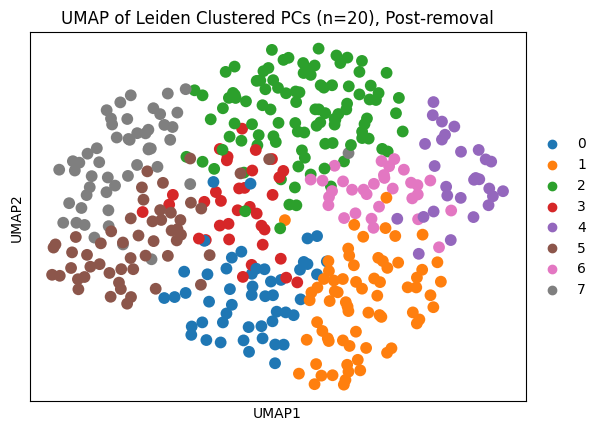

In [2]:
pp = Preprocessor()
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')
ct_counts_metadata = pp.remove_features(ct_counts_metadata, ['Exc RELN CHD7'])

In [3]:
# Regress out
pp.regress_out(ct_counts_metadata, 'pmi')

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.


In [4]:
cat = Categorizer(True)
braaksc_map = {0: 'L', 1: 'L', 2: 'L', 3: 'L', 4: 'H', 5: 'H', 6: 'H'}
cat.categorize(ct_counts_metadata, 'braaksc', braaksc_map, True)
ct_counts_metadata.obs['braaksc_cat'].value_counts()

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/categorizer.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


braaksc_cat
L    215
H    201
Name: count, dtype: int64

log2( fold change ) = log2( H/L )


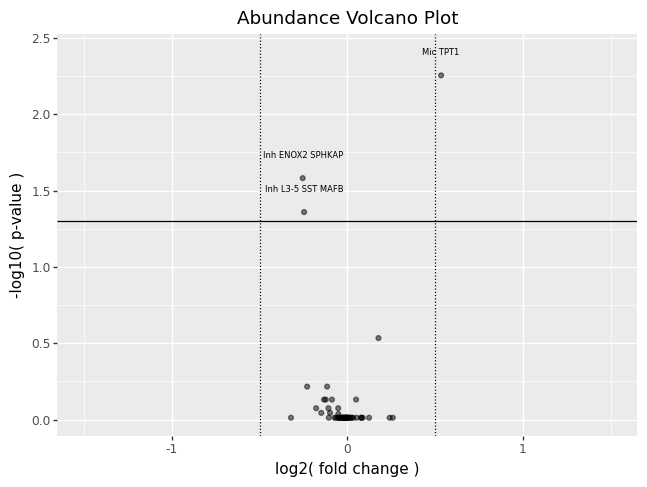

In [5]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

diff = Differentiator('l1', ranksums, fdrcorrection, 'braaksc_cat', ('H', 'L'))
diff.differentiate(ct_counts_metadata)
diff.volcano_plot(ct_counts_metadata)

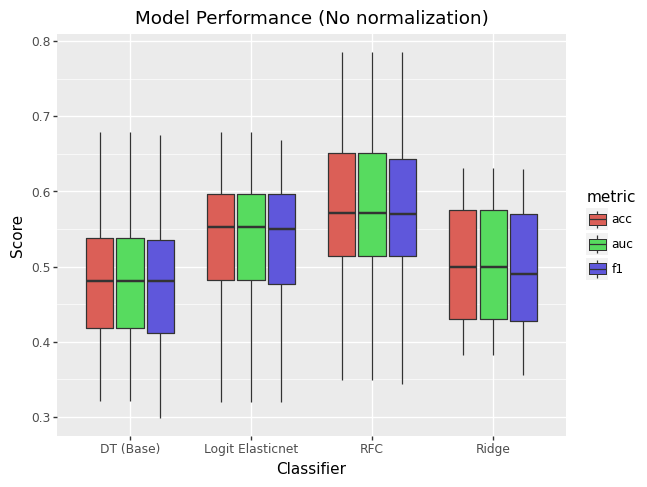

In [6]:
# Test models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

tester = ModelTester(None, DecisionTreeClassifier(), 'braaksc_catcode', [0, 1], 15, random_state=42, verbose=False)
tester.test_baseline(ct_counts_metadata, 'DT (Base)')
tester.test_models(ct_counts_metadata, 
                   [RandomForestClassifier(), RidgeClassifier(), LogisticRegression('elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)], 
                   ['RFC', 'Ridge', 'Logit Elasticnet'])
tester.plot_results('Model Performance (No normalization)')

In [7]:
# Filter out
ct_counts_filtered = ct_counts_metadata[ct_counts_metadata.obs['cogdx'].isin([1, 4, 5])]

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/differentiator.py:57: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


log2( fold change ) = log2( H/L )


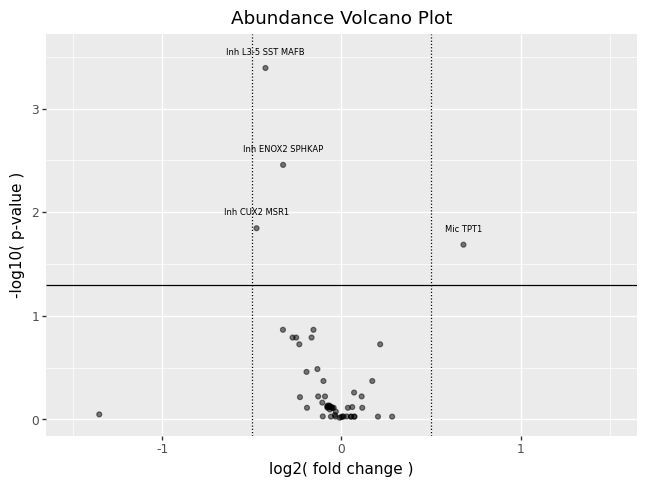

In [8]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

diff = Differentiator('l1', ranksums, fdrcorrection, 'braaksc_cat', ('H', 'L'))
diff.differentiate(ct_counts_filtered)
diff.volcano_plot(ct_counts_filtered)

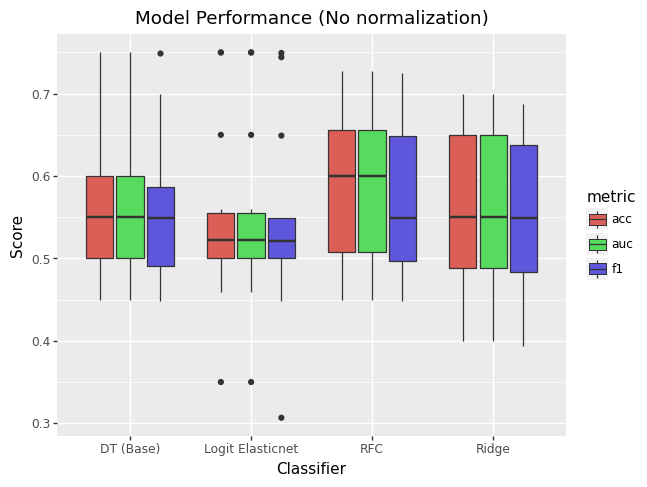

In [9]:
filt_tester = ModelTester(None, DecisionTreeClassifier(), 'braaksc_catcode', [0, 1], 15, random_state=42, verbose=False)
filt_tester.test_baseline(ct_counts_filtered, 'DT (Base)')
filt_tester.test_models(ct_counts_filtered, 
                        [RandomForestClassifier(), RidgeClassifier(), LogisticRegression('elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)], 
                        ['RFC', 'Ridge', 'Logit Elasticnet'])
filt_tester.plot_results('Model Performance (No normalization)')